### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv", index_col='RowNumber')
df.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [9]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve, confusion_matrix

results = pd.DataFrame(index=['rf', 'boost', 'lr'], columns=['precision', 'recall', 'f1', 'roc_auc', 'income'])

In [11]:
def get_metrics(probs, model):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    results.loc[model,'precision':'roc_auc']= precision[ix], recall[ix],fscore[ix],roc_auc_score(y_test, probs)
    return thresholds[ix]

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    font = {'size' : 13}
    plt.rc('font', **font)
    plt.figure(figsize=(6, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=13)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.420000, F-Score=0.638, Precision=0.701, Recall=0.585, Roc-AUC=0.864


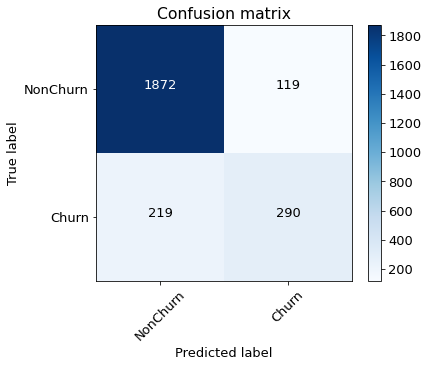

In [14]:
preds = pipeline.predict_proba(X_test)[:, 1]

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

cnf_matrix = confusion_matrix(y_test, preds>get_metrics(preds,'rf'))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

results.loc['rf', 'income'] = TP*2-(TP+FP)*1

## GradientBoosting

In [15]:
boost_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=13))
])
boost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc-AUC=0.876


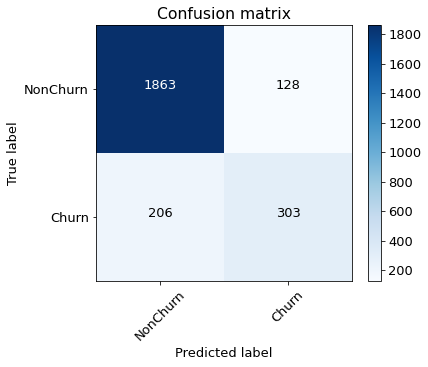

In [16]:
preds = boost_pipeline.predict_proba(X_test)[:, 1]

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

boost_cnf_matrix = confusion_matrix(y_test, preds>get_metrics(preds, 'boost'))
plot_confusion_matrix(boost_cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')

TP = boost_cnf_matrix[1][1]
FP = boost_cnf_matrix[0][1]

results.loc['boost', 'income'] = TP*2-(TP+FP)*1

## LogisticRegression

In [17]:
lr_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=13))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, Roc-AUC=0.772


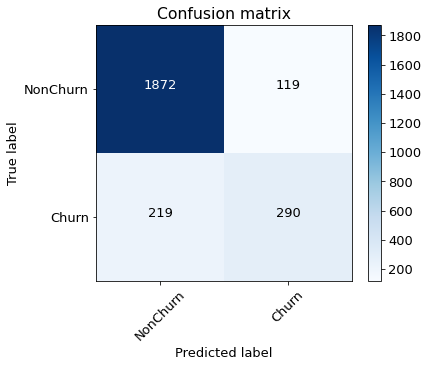

In [18]:
preds = lr_pipeline.predict_proba(X_test)[:, 1]

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

lr_cnf_matrix = confusion_matrix(y_test, preds>get_metrics(preds, 'lr'))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')

TP = lr_cnf_matrix[1][1]
FP = lr_cnf_matrix[0][1]

results.loc['lr', 'income'] = TP*2-(TP+FP)*1

## Выбор модели

Оценим результаты на текущий момент:

In [19]:
results

,precision,recall,f1,roc_auc,income
rf,0.701176,0.585462,0.638116,0.86425,171
boost,0.703704,0.59725,0.646121,0.875738,175
lr,0.4624,0.56778,0.5097,0.772077,-48


Видим, что по всем параметрам бустинг показал себя лучше всего. С учетом того, что в дальнейшем мы планируем вкладываться в удержание пользователей, нам нужно будет снижать FP и повышать TP, что в определенном есть метрика precision. Однако, почему бы нам не воспользоваться метрикой дохода напрямую.

In [20]:
from sklearn.metrics import make_scorer

def my_scorer(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    income = TP*2-(TP+FP)*1
    return income

my_func = make_scorer(my_scorer, greater_is_better=True)

## Подбор параметров

In [21]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=13))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [22]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators': range(100, 401, 50),
        'classifier__max_depth': range(3,5),
        'classifier__learning_rate': [0.001, 0.01, 0.1]
        }

Запускаем перебор

In [23]:
import warnings
warnings.filterwarnings("ignore")

grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=5,
                    refit=False, 
                    scoring=my_func)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__n_estimators': 150}

In [24]:
tuned_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=13, n_estimators=150, max_depth=4))
])
tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.329822, F-Score=0.636, Precision=0.606, Recall=0.670, Roc-AUC=0.874


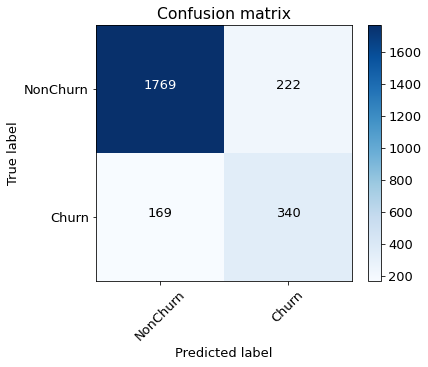

In [25]:
results.append(pd.Series(name='tuned'))
preds = tuned_pipeline.predict_proba(X_test)[:, 1]

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

tuned_cnf_matrix = confusion_matrix(y_test, preds>get_metrics(preds, 'tuned'))
plot_confusion_matrix(tuned_cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')

TP = tuned_cnf_matrix[1][1]
FP = tuned_cnf_matrix[0][1]

results.loc['tuned', 'income'] = TP*2-(TP+FP)*1

In [26]:
results

,precision,recall,f1,roc_auc,income
rf,0.701176,0.585462,0.638116,0.86425,171
boost,0.703704,0.59725,0.646121,0.875738,175
lr,0.4624,0.56778,0.5097,0.772077,-48
tuned,0.605684,0.669941,0.636194,0.873922,118


Модель бустинга с базовыми параметрами оказалась наилучшим вариантом.